In [19]:
from pathlib import Path
import re, numpy as np, pandas as pd, mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

In [3]:
from src.feature_extraction import epochs_to_bandpower
from src.feature_extraction import reduce_features

In [4]:
DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

### Select which runs to extract epochs from

In [20]:
paths = sorted(DER.glob("*-epo.fif"))
# paths = [p for p in paths if re.search(r"R(03|04|07|08|11|12)", p.name)] # only these subjects have both L and R hand MI
# paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only
paths = [p for p in paths if re.search(r"R(03|07|11)", p.name)]  # L/R exec only
# paths = [p for p in paths if re.search(r"R(06|10|14)", p.name)]  # both imagery only

print("Files:", len(paths))


Files: 318


### Load epochs, extract bandpower features, and concatenate across all files

In [103]:
X_all, y_all, runs, subjs, files_used = [], [], [], [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)
    if len(ep) == 0:
        # print(f"Skip (empty): {p.name}")
        continue

    X, y, chs, bns = epochs_to_bandpower(ep)
    m = re.search(r"R(\d{2})", p.name); run = int(m.group(1)) if m else -1; 
    subj_name = re.search(r"(S\d{3})", p.name).group(1) 
    subj_number = int(subj_name.lstrip("S"))
    X_all.append(X); y_all.append(y); runs.extend([run]*len(y)); subjs.extend([subj_number] * len(y)); files_used.append(p.name)
    
X = np.vstack(X_all); y = np.concatenate(y_all); runs = np.array(runs)
print(
    f"X shape: {X.shape}\n"
    f"Y shape: {y.shape}\n"
    f"Runs shape: {runs.shape}\n"
    f"subjects shape: {len(subjs)}\n"
    f"Unique runs: {np.unique(runs)}\n"
    f"Unique labels: {np.unique(y)}\n"
    f"Unique subjects: {np.unique(subjs)}"
)


X shape: (1266, 256)
Y shape: (1266,)
Runs shape: (1266,)
subjects shape: 1266
Unique runs: [ 3  7 11]
Unique labels: [1 2]
Unique subjects: [  1   2   4   6   7   8  10  11  12  14  16  18  20  25  26  29  30  31
  33  34  35  37  40  41  42  44  45  47  50  51  55  57  59  62  63  64
  66  67  71  72  73  74  76  78  80  81  82  85  87  89  93  98 102 104
 105 107 108]


# Data exploration

In [104]:
# convert data to dataframe for easier handling
n_samples, n_features = X.shape
feature_names = [f"f{i+1}" for i in range(n_features)]
df_X = pd.DataFrame(X, columns=feature_names)
df_y = pd.DataFrame(y, columns=["label"])
df_runs = pd.DataFrame(runs, columns=["run"])
df_subjs = pd.DataFrame(subjs, columns=["subject"])
df = pd.concat([df_X, df_y, df_runs, df_subjs], axis=1)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f250,f251,f252,f253,f254,f255,f256,label,run,subject
0,-10.899988,-11.043146,-11.127990,-11.128700,-11.086014,-11.248554,-11.324826,-10.900050,-10.954291,-11.395118,...,-11.498937,-11.562839,-11.534085,-11.452269,-11.466645,-11.411654,-11.384385,1,7,1
1,-11.203984,-11.370694,-11.332728,-11.290575,-11.346758,-11.467783,-11.751206,-11.405654,-11.109273,-11.124177,...,-11.816257,-11.937613,-11.918060,-11.833467,-11.931678,-11.853158,-11.926145,1,3,2
2,-11.396883,-11.517307,-11.615792,-11.500148,-11.697128,-11.713902,-11.405218,-11.654353,-11.858030,-11.463409,...,-11.577680,-11.610825,-11.603847,-11.606789,-11.415285,-11.389378,-11.432619,1,3,2
3,-11.620116,-11.639113,-11.789570,-11.616954,-11.608464,-11.550864,-11.352737,-11.651074,-11.364287,-11.312846,...,-11.668317,-11.826642,-11.641616,-11.667768,-11.718213,-11.719671,-11.693196,2,3,2
4,-11.568807,-11.228480,-11.237295,-11.172238,-11.156028,-11.273518,-11.495918,-11.503444,-11.352284,-11.243346,...,-11.526648,-11.573623,-11.537369,-11.520725,-11.501939,-11.379961,-11.494487,2,7,2


### Class balance

label
2    0.504739
1    0.495261
Name: count, dtype: float64


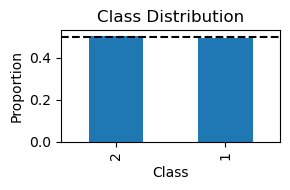

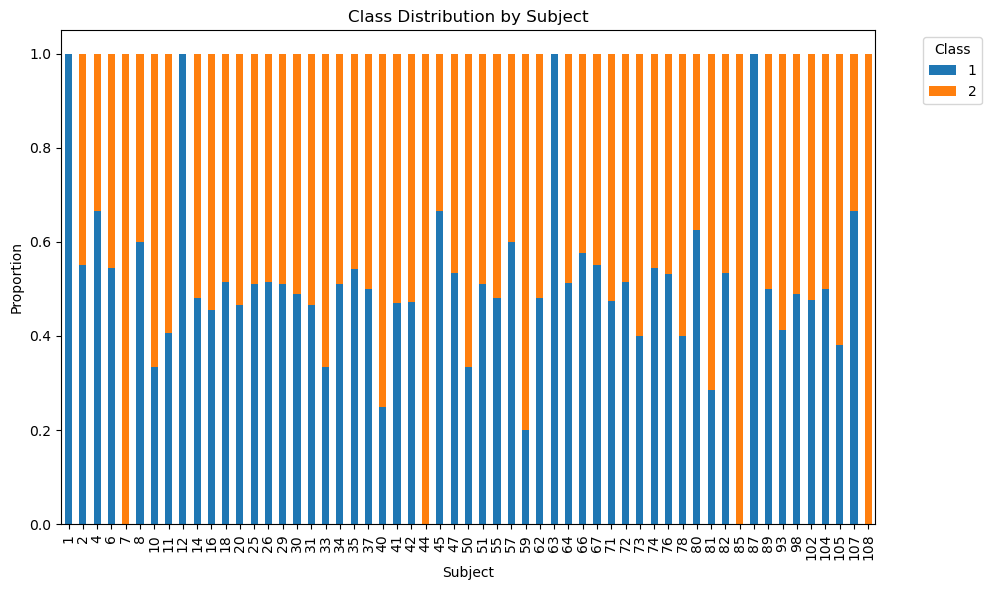

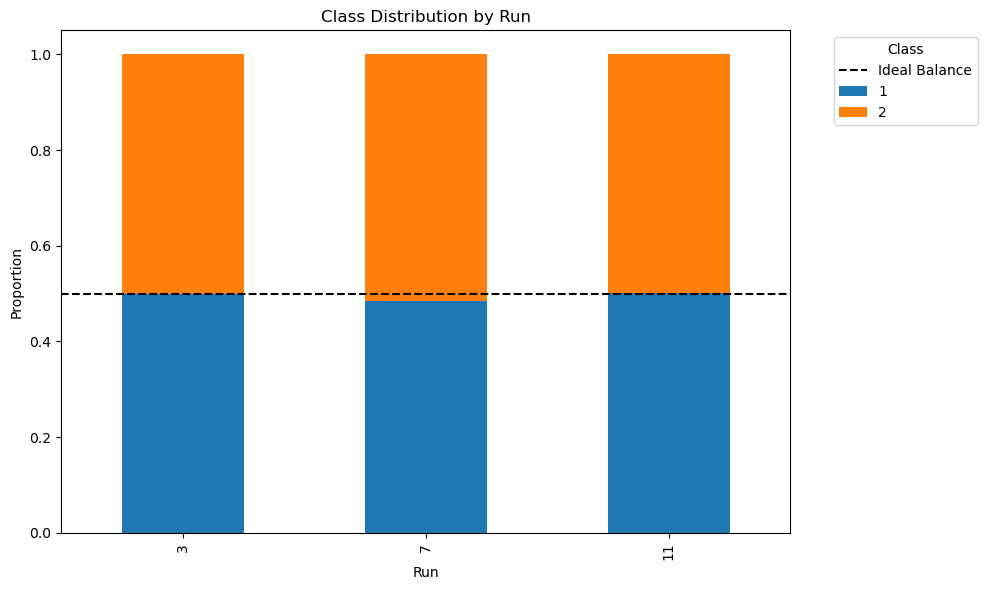

In [119]:
# check class balance
print(f"{df['label'].value_counts()/len(df)}")  
plt.figure(figsize=(3,2))
df['label'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution', ylabel='Proportion', xlabel='Class')
plt.axhline(0.5, color='black', linestyle='--', label='Ideal Balance')
plt.tight_layout()
plt.show()

# By subject class balance
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
df.groupby('subject')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax)
plt.title('Class Distribution by Subject')
plt.ylabel('Proportion')
plt.xlabel('Subject')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# By run class balance
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
df.groupby('run')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax)
plt.axhline(0.5, color='black', linestyle='--', label='Ideal Balance')
plt.title('Class Distribution by Run')
plt.ylabel('Proportion')
plt.xlabel('Run')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Per feature summary

In [120]:
# per feature summary
feature_summary = df_X.describe().T
feature_summary['range'] = feature_summary['max'] - feature_summary['min']
feature_summary = feature_summary[['min', 'max', 'range', 'mean', 'std', '25%', '50%', '75%']]
feature_summary.head()  

,min,max,range,mean,std,25%,50%,75%
f1,-11.983579,-10.359260,1.624319,-11.597192,0.308822,-11.843141,-11.684341,-11.420237
f2,-11.990699,-10.436001,1.554698,-11.646359,0.288128,-11.876685,-11.736005,-11.481707
f3,-11.992377,-10.420561,1.571816,-11.638352,0.305080,-11.881586,-11.743779,-11.464106
f4,-11.995044,-10.384126,1.610918,-11.630490,0.304439,-11.879690,-11.726138,-11.444309
f5,-11.993043,-10.467791,1.525252,-11.639470,0.297863,-11.878240,-11.733392,-11.460158


In [124]:
# outlier features - extremely high and low std values
print(df_X.std().sort_values().head(10))
print(df_X.std().sort_values().tail(10))

f219    0.092713
f212    0.094544
f213    0.094842
f243    0.095180
f244    0.096974
f245    0.098166
f211    0.098622
f208    0.099777
f242    0.100245
f241    0.102238
dtype: float64
f20    0.374513
f53    0.374605
f62    0.374750
f57    0.385718
f58    0.388653
f59    0.394434
f61    0.400680
f56    0.402917
f63    0.403268
f60    0.415319
dtype: float64


### Low-dimensional feature representation

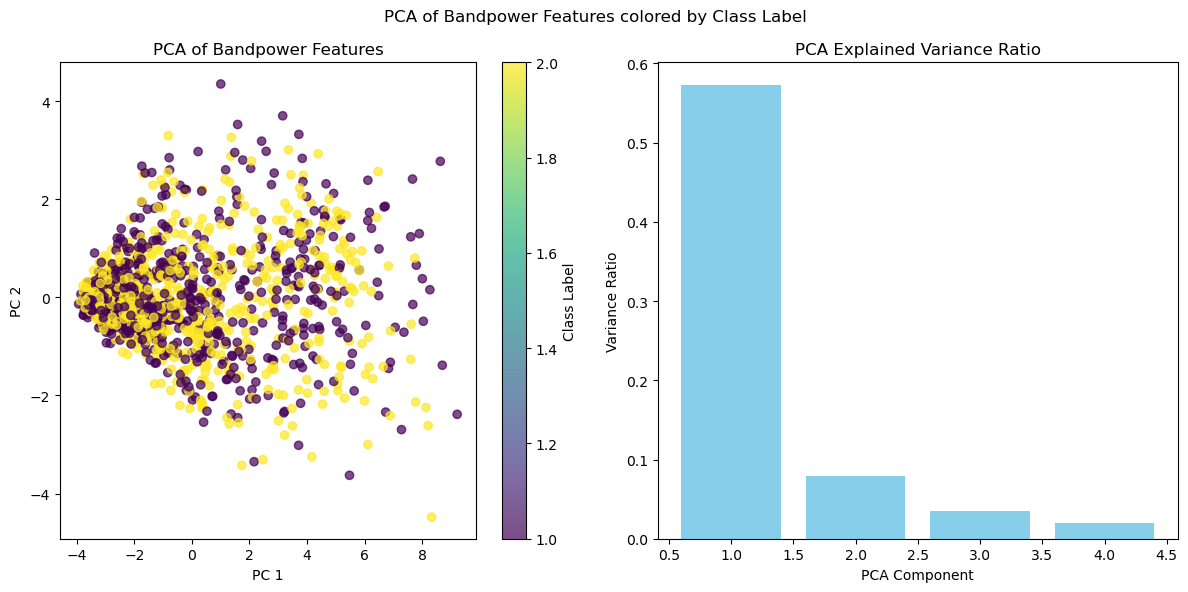

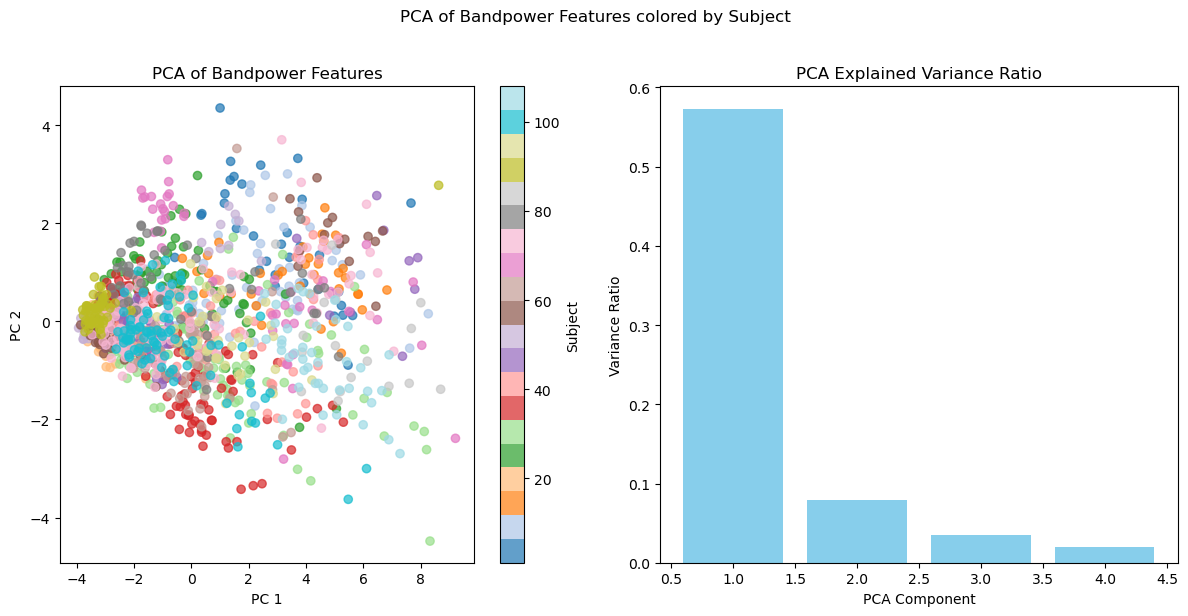

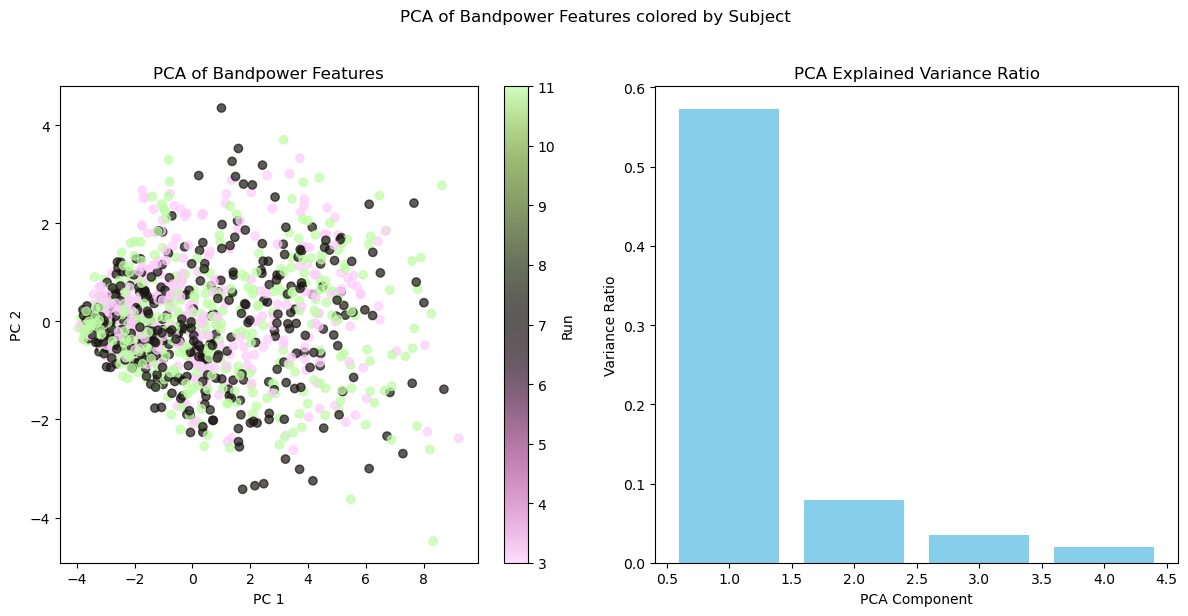

In [ ]:
from sklearn.decomposition import PCA

### Low-dimensional feature representation
pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_X)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['label'], cmap='viridis', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Class Label')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Class Label')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['subject'], cmap='tab20', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Subject')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Subject', y=1.02)    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['run'], cmap='vanimo', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Run')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Subject', y=1.02)    
plt.tight_layout()
plt.show()

# ML pipleine

In [46]:
groups = runs # could also use subjs here

In [57]:
print(
    f"X shape: {X.shape}\n"
    f"Y shape: {y.shape}\n"
    f"groups shape: {groups.shape}\n"
    f"Unique groups: {np.unique(groups)}\n"
    f"Unique labels: {np.unique(y)}\n"
)

X shape: (1266, 256)
Y shape: (1266,)
groups shape: (1266,)
Unique groups: [ 3  7 11]
Unique labels: [1 2]



### 1.1 Train-Test split

In [68]:
# Held out test split (group-aware)
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

In [69]:
np.unique(groups_train), np.unique(groups_test)

(array([ 7, 11]), array([3]))

### 1.2 CV strategy for model selection (group-aware)

In [61]:
# cv = GroupKFold(n_splits=5)
cv = LeaveOneGroupOut()

### 1.3 Make pipeline

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

### 1.4 Hyperparameter tuning on training data

In [63]:
param_grid = {
    "clf__C": [0.0001, 0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__penalty": ["l2"]
}
### Hyperparameter tuning on training data
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train, groups=groups_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV score: 0.6612673604566218


### 1.5 Final eval on test set

In [64]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test set results:
Accuracy: 0.7387173396674585
Cohen's Kappa: 0.47752606164538114
F1-score: 0.7383852307136078
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.78      0.75       210
           2       0.76      0.70      0.73       211

    accuracy                           0.74       421
   macro avg       0.74      0.74      0.74       421
weighted avg       0.74      0.74      0.74       421



# Testing multiple ML models

### 2.4 Testing multiple models

In [ ]:
param_grid = [
    {}
]

In [ ]:

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lda = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),  # ok with LDA
    ("clf", LDA())
])

models = {"logreg": logreg, "lda": lda}


In [9]:
def eval_group_kfold(model, X, y, groups, n_splits=5):

    # n_splits = min(5, np.unique(groups).size) 
    # gkf = GroupKFold(n_splits=n_splits)
    gkf = LeaveOneGroupOut()  # LOPOCV
    mets = []
    cms  = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        model.fit(X[tr], y[tr])
        yhat = model.predict(X[te])
        mets.append({
            "fold": fold,
            "acc": accuracy_score(y[te], yhat),
            "kappa": cohen_kappa_score(y[te], yhat),
            "f1_macro": f1_score(y[te], yhat, average="macro")
        })
        cms.append(confusion_matrix(y[te], yhat))
    df = pd.DataFrame(mets)
    return df, cms

rows = []
for name, mdl in models.items():
    df, cms = eval_group_kfold(mdl, X, y, groups, n_splits=5)
    print(name, df.mean(numeric_only=True).round(3))
    rows.append(dict(model=name, **{k: float(v) for k,v in df.mean(numeric_only=True).items()}))


logreg fold        1.000
acc         0.673
kappa       0.345
f1_macro    0.672
dtype: float64
lda fold        1.000
acc         0.642
kappa       0.283
f1_macro    0.641
dtype: float64


In [25]:
print(f"X.shape={X.shape}, y.shape={y.shape}, groups.shape={groups.shape}")

print(f"1st entry of y: {y[0]}")
print(f"1st entry of groups: {groups[0]}")
print(f"1st entry of X: {X[0]}")

X.shape=(1266, 256), y.shape=(1266,), groups.shape=(1266,)
1st entry of y: 1
1st entry of groups: 7
1st entry of X: [-10.89998754 -11.043146   -11.12798985 -11.12870001 -11.08601385
 -11.24855373 -11.32482579 -10.90005035 -10.9542908  -11.39511756
 -11.20983438 -10.77409197 -10.81641962 -10.92906911 -10.69111595
 -10.93780172 -11.59035863 -11.52416103 -11.03250193 -10.90895427
 -10.89458433 -11.15129198 -11.03565893 -11.19788014 -11.25461889
 -11.24499154 -10.97889525 -11.20836524 -11.35269638 -11.00528112
 -11.09573384 -11.16030467 -11.16290183 -11.09765758 -11.14482121
 -11.20591171 -11.47387846 -11.22108353 -11.05243669 -11.32805722
 -10.99253217 -11.21702017 -11.16701924 -11.1385937  -10.81356165
 -11.00651629 -10.73497954 -10.70125668 -10.94332917 -11.11780594
 -11.4287156  -11.15770781 -10.93006148 -10.94658672 -11.10891684
 -10.79515037 -10.80947817 -11.16150387 -11.02281107 -11.17407379
 -11.0234177  -11.44376262 -10.982988   -11.41371699 -11.1374519
 -10.49334698 -10.4306551  

In [10]:
# Subject groups
subs = []
for p in paths:
    m = re.search(r"S(\d{3})", p.name); subj = int(m.group(1)) if m else -1
    ep = mne.read_epochs(p, preload=False, verbose=False)
    subs.extend([subj]*len(ep))
subs = np.array(subs)

df_subj, _ = eval_group_kfold(models["logreg"], X, y, subs, n_splits=len(np.unique(subs)))
print("LOSO(logreg):", df_subj.mean(numeric_only=True).round(3))
rows.append(dict(model="logreg_LOSO", **{k: float(v) for k,v in df_subj.mean(numeric_only=True).items()}))


/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_class

LOSO(logreg): fold        28.000
acc          0.666
kappa        0.315
f1_macro     0.642
dtype: float64


/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [11]:
rows

[{'model': 'logreg',
  'fold': 1.0,
  'acc': 0.6726941731164358,
  'kappa': 0.3447737397833684,
  'f1_macro': 0.6719938341031795},
 {'model': 'lda',
  'fold': 1.0,
  'acc': 0.6416701025160146,
  'kappa': 0.28263115869154315,
  'f1_macro': 0.641102581473248},
 {'model': 'logreg_LOSO',
  'fold': 28.0,
  'acc': 0.6664209273355656,
  'kappa': 0.3146721646318974,
  'f1_macro': 0.6419274231551438}]

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best = max(rows, key=lambda r: r["kappa"])
print("Best:", best)

# Refit on all data to plot CM using a simple random 20% hold-out, just for a figure
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(tr, te), = sss.split(X, y)
model = models[best["model"].split("_")[0]]
model.fit(X[tr], y[tr]); yhat = model.predict(X[te])
disp = ConfusionMatrixDisplay.from_predictions(y[te], yhat)
plt.title(f"CM — {best['model']}  acc={accuracy_score(y[te],yhat):.2f}  κ={cohen_kappa_score(y[te],yhat):.2f}")
plt.tight_layout()
plt.savefig(FIGS / f"confusion_matrix_{best['model']}_bandpower.png", dpi=150)
plt.close()


Best: {'model': 'logreg', 'fold': 1.0, 'acc': 0.6726941731164358, 'kappa': 0.3447737397833684, 'f1_macro': 0.6719938341031795}


### Visualize mean of channel bandpowers vs class

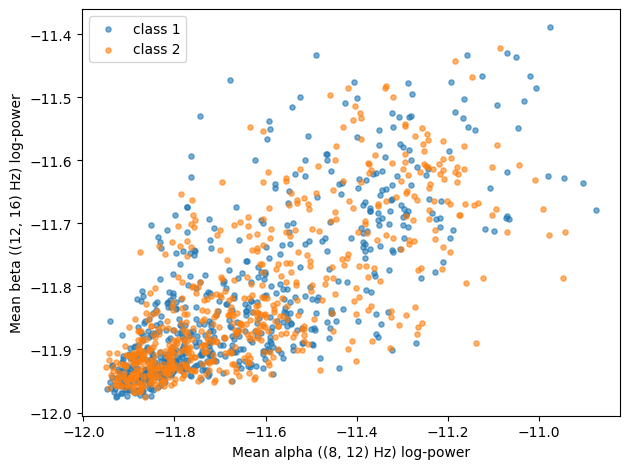

In [16]:
from feature_extraction import BANDS

n_ch = X.shape[1] // 2                # first half = alpha(μ), second half = beta
alpha_mean = X[:, :n_ch].mean(axis=1) # mean over channels
beta_mean  = X[:, n_ch:].mean(axis=1)

plt.figure()
for cls in np.unique(y):
    m = (y == cls)
    plt.scatter(alpha_mean[m], beta_mean[m], s=14, alpha=0.6, label=f"class {cls}")
plt.xlabel(f"Mean {list(BANDS.keys())[0]} ({list(BANDS.values())[0]} Hz) log-power")
plt.ylabel(f"Mean {list(BANDS.keys())[1]} ({list(BANDS.values())[1]} Hz) log-power")
plt.legend(); plt.tight_layout()


### Un-supervised dimensionality reduction

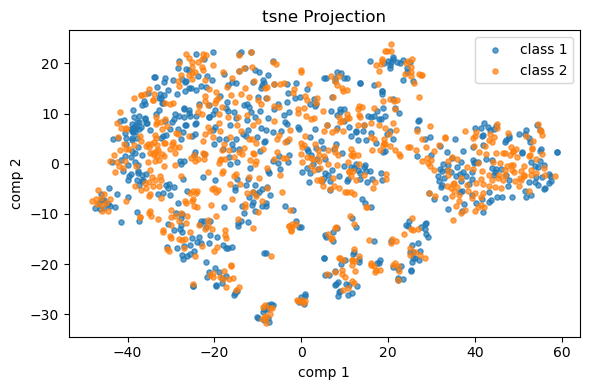

In [28]:
# Dimensionality reduction for visualization
method = "tsne"
Z, mdl, info = reduce_features(X, method=method, n_components=2)
# print("PCA explained variance:", np.round(info.get("expl_var", []), 3))

# Scatter by class
plt.figure(figsize=(6,4))
for cls in np.unique(y):
    m = (y == cls)
    plt.scatter(Z[m,0], Z[m,1], s=14, alpha=0.7, label=f"class {cls}")
plt.xlabel("comp 1"); plt.ylabel("comp 2"); plt.title(f"{method} Projection"); plt.legend(); plt.tight_layout()
plt.show()



### Supervised dimensionality reduction (LDA)

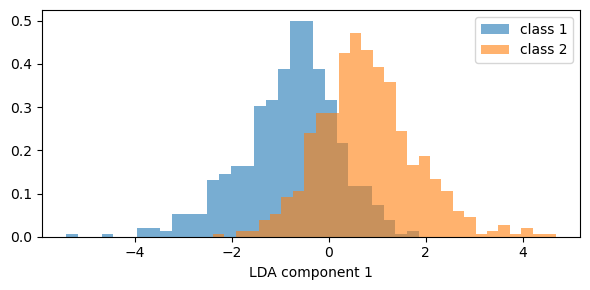

In [18]:
Z, mdl, info = reduce_features(X, y=y, method="lda", n_components=1) # supervised

plt.figure(figsize=(6,3))
for cls in np.unique(y):
    m = (y == cls)
    plt.hist(Z[m, 0], bins=30, alpha=0.6, label=f"class {cls}", density=True)
plt.xlabel("LDA component 1"); plt.legend(); plt.tight_layout()
